# Covid-19-Wörter vor und nach Covid-19 - Überprüfung

#### Lemmas
- Abstandsregel
- Corona
- Maske
- Kontaktverbot
- Querdenker

## Importe und Datenvorbereitung

In [1]:
import codecs
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import re
import scipy
import seaborn as sns
import spacy
import statistics 

from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from gensim.models.phrases import Phraser, Phrases
from joblib import Parallel, delayed  
from nltk.corpus import stopwords
from scipy import spatial
from sklearn.manifold import TSNE
from tabulate import tabulate

In [2]:
nlp = spacy.load('de_core_news_md')
stopwords = stopwords.words('german')
tokenizer = nltk.data.load('tokenizers/punkt/german.pickle')

#### Korpus laden und vorbereiten

In [3]:
# die Datei enthält alle Treffer der oben genannten Lemmas im ZDL-Regionalkorpus des DWDS 
# mit jeweils einem Satz Kontext davor und danach

df = pd.read_csv('../data/covid-vocab_1993-2021.csv', sep=',', encoding='utf-8')
df.head()

,Corpus,Date,Genre,Bibl,ContextBefore,Hit,ContextAfter
0,saar_regional,1993-02-01,Zeitung,"Saarbrücker Zeitung, 01.02.1993",Filmprogramme Neunkirchen.,"Corona 1: ""Bodyguard"" 15.30, 17.45, 20.15 Uhr.","Corona 2: ""Whoopi Sister act, eine himmlische ..."
1,saar_regional,1993-02-01,Zeitung,"Saarbrücker Zeitung, 01.02.1993",NaN,Von der farbkräftigen Maske (Venezianischer Tr...,NaN
2,saar_regional,1993-02-01,Zeitung,"Saarbrücker Zeitung, 01.02.1993","Corona 1: ""Bodyguard"" 15.30, 17.45, 20.15 Uhr.","Corona 2: ""Whoopi Sister act, eine himmlische ...","Burg 1:15.15, 17.45 und 20.15 Uhr ""Der letzte ..."
3,saar_regional,1993-02-03,Zeitung,"Saarbrücker Zeitung, 03.02.1993","Corona 1: ""Bodyguard"" 15.30, 17.45, 20.15 Uhr.","Corona 2: ""Whoopi Sister act, eine himmlische ...","Burg 1:15.15, 17.45 und 20.15 Uhr ""Der letzte ..."
4,saar_regional,1993-02-03,Zeitung,"Saarbrücker Zeitung, 03.02.1993",Filmprogramme Neunkirchen.,"Corona 1: ""Bodyguard"" 15.30, 17.45, 20.15 Uhr.","Corona 2: ""Whoopi Sister act, eine himmlische ..."


In [4]:
# NaN durch Whitespace ersetzen

df = df.fillna(' ')

In [5]:
# Wörter, die mit [...] anfangen löschen

expression = '\[...]\w*'
df = df.replace(to_replace = expression, value = ' ', regex=True)

In [6]:
# bevor die Spalten verbunden werden: Whitespace einfügen, um ein Aneinanderkleben der Wörter zu verhindern

df['ContextBefore'] = df['ContextBefore'].astype(str) + ' '
df['ContextAfter'] = ' ' + df['ContextAfter'].astype(str) 

In [7]:
# Text zu einer Spalte verbinden

columns = ['ContextBefore', 'Hit', 'ContextAfter']

df['Text'] = df[columns].astype(str).sum(axis=1)
df.head()

,Corpus,Date,Genre,Bibl,ContextBefore,Hit,ContextAfter,Text
0,saar_regional,1993-02-01,Zeitung,"Saarbrücker Zeitung, 01.02.1993",Filmprogramme Neunkirchen.,"Corona 1: ""Bodyguard"" 15.30, 17.45, 20.15 Uhr.","Corona 2: ""Whoopi Sister act, eine himmlische...","Filmprogramme Neunkirchen. Corona 1: ""Bodyguar..."
1,saar_regional,1993-02-01,Zeitung,"Saarbrücker Zeitung, 01.02.1993",,Von der farbkräftigen Maske (Venezianischer Tr...,,Von der farbkräftigen Maske (Venezianischer ...
2,saar_regional,1993-02-01,Zeitung,"Saarbrücker Zeitung, 01.02.1993","Corona 1: ""Bodyguard"" 15.30, 17.45, 20.15 Uhr.","Corona 2: ""Whoopi Sister act, eine himmlische ...","Burg 1:15.15, 17.45 und 20.15 Uhr ""Der letzte...","Corona 1: ""Bodyguard"" 15.30, 17.45, 20.15 Uhr...."
3,saar_regional,1993-02-03,Zeitung,"Saarbrücker Zeitung, 03.02.1993","Corona 1: ""Bodyguard"" 15.30, 17.45, 20.15 Uhr.","Corona 2: ""Whoopi Sister act, eine himmlische ...","Burg 1:15.15, 17.45 und 20.15 Uhr ""Der letzte...","Corona 1: ""Bodyguard"" 15.30, 17.45, 20.15 Uhr...."
4,saar_regional,1993-02-03,Zeitung,"Saarbrücker Zeitung, 03.02.1993",Filmprogramme Neunkirchen.,"Corona 1: ""Bodyguard"" 15.30, 17.45, 20.15 Uhr.","Corona 2: ""Whoopi Sister act, eine himmlische...","Filmprogramme Neunkirchen. Corona 1: ""Bodyguar..."


In [8]:
# Größe des DF

df.shape

(416493, 8)

#### Korpus shuffeln und random in der Mitte in zwei Teile teilen

In [14]:
# Shuffeln 

df_shuffled = df.sample(frac=1).reset_index(drop=True)
df_shuffled.head()

,Corpus,Date,Genre,Bibl,ContextBefore,Hit,ContextAfter,Text
0,mib_regional,2020-08-28,Zeitung,"Mittelbayerische, 28.08.2020",Beginn ist um 8 Uhr.,Masken werden gestellt.,Kosten pro Person 30 Euro.,Beginn ist um 8 Uhr. Masken werden gestellt. K...
1,saar_regional,2003-03-06,Zeitung,"Saarbrücker Zeitung, 06.03.2003","""Ring"" von Gore Verbinski (USA 2002).","- Cinestar (Sb), PK2 (Sb), Eden (Hom), Corona ...","""Ein Chef zum Verlieben"" von Marc Lawrence (U...","""Ring"" von Gore Verbinski (USA 2002). - Cinest..."
2,rztg_regional,2005-04-14,Zeitung,"Rhein-Zeitung, 14.04.2005",Unterlagen des Klosters eine Antwort zu find...,"Vorerst hat man nur das Bildmaterial zur Hand,...",Da sieht man etliche der Patres beim fleißige...,Unterlagen des Klosters eine Antwort zu find...
3,sk_regional,2011-03-07,Zeitung,"Südkurier, 07.03.2011","sich die ""Highlander"" aus Basel am Narresams...",Mit ihren gelb-karierten Kilts und Plaits und ...,Die Kinder der Maisenhardt-Joggele tanzten ih...,"sich die ""Highlander"" aus Basel am Narresams..."
4,saar_regional,2021-01-28,Zeitung,"Saarbrücker Zeitung, 28.01.2021",Kolumne Lock-Buch,Warum nicht Corona wegzaubern?,Ich kann nicht zaubern.,Kolumne Lock-Buch Warum nicht Corona wegzauber...


In [15]:
416493/2

208246.5

In [16]:
# Korpus in 2 Teilkorpora (Grenze in der Mitte des geshuffelten DF)

df1 = df_shuffled.iloc[:208246,:]
df2 = df_shuffled.iloc[208247:,:]

In [17]:
df2.head()

,Corpus,Date,Genre,Bibl,ContextBefore,Hit,ContextAfter,Text
208247,svz_regional,2020-04-20,Zeitung,"Schweriner Volkszeitung, 20.04.2020",", die dort, wo sie die größte filmische Wirku...",Einige dieser Objekte beschäftigen sich direkt...,Indem die Künstlerin sich selbst mehrfach mas...,", die dort, wo sie die größte filmische Wirku..."
208248,lvz_regional,2021-06-23,Zeitung,"Leipziger Volkszeitung, 23.06.2021",je 100000 Einwohner nachweislich an - wie in...,Ab Mitte Juli könnten laut der Einschätzung de...,"Bisher wurden in Tschechien mit seinen 10,7 M...",je 100000 Einwohner nachweislich an - wie in...
208249,laz_regional,2020-04-09,Zeitung,"Landshuter Zeitung, 09.04.2020",(red),Der Bauernmarkt beim Biller ist trotz Corona K...,Diese Woche findet der Bauernmarkt am heutige...,(red) Der Bauernmarkt beim Biller ist trotz Co...
208250,dnn_regional,2021-02-12,Zeitung,"Dresdner Neueste Nachrichten, 12.02.2021",Sicher durch die Krise:,Das lernen die DVB aus Corona,Das Hygieneregime und vor allem eine klare Ko...,Sicher durch die Krise: Das lernen die DVB aus...
208251,rztg_regional,2011-08-02,Zeitung,"Rhein-Zeitung, 02.08.2011",,"Kirchen, Selbsthilfegruppe Schlafapnoe/Chronis...",,"Kirchen, Selbsthilfegruppe Schlafapnoe/Chron..."


In [18]:
# Größe der Teilkorpora im Vergleich

print(df1.shape, df2.shape)

(208246, 8) (208246, 8)


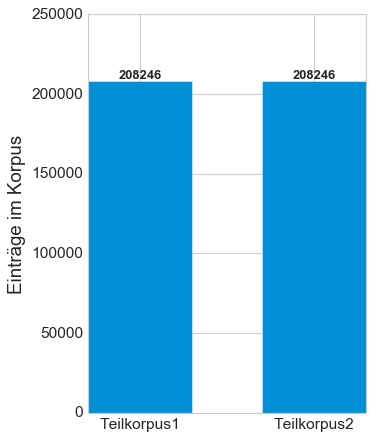

In [22]:
plt.figure(figsize=[4, 6])
plt.style.use('seaborn-whitegrid')

data = [208246, 208246]
labels = ['Teilkorpus1', 'Teilkorpus2']

plt.xticks(range(len(data)), labels)
plt.ylabel('Einträge im Korpus')
plt.bar(range(len(data)), data, width=0.6)

for i, j in zip(range(len(data)), data):
    plt.annotate(j, xy=(i,j), xycoords='data', verticalalignment='bottom', horizontalalignment='center', 
                 fontsize='small', fontweight='demi')
    
#plt.savefig('../plots/Korpusvergleich_Shuffled.png', bbox_inches='tight')
plt.show()

#### Hilfsfunktionen zur Vorbereitung der Texte

In [29]:
def lemmatize_text_column(df, column):
    """
    transforms the Dataframe-column in a lemmatized string
    """
    text = ''
    for i in df[column]:
        doc = nlp(i)
        lemmas = ' '.join([x.lemma_ for x in doc])
        text = text + lemmas
    return text


def sentence_to_wordlist(raw:str):
    """
    cleans and tokenizes the sentences
    """
    text = re.sub('[^A-Za-z_äÄöÖüÜß]',' ', raw).split()                              
    filtered_text = [word for word in text if word not in stopwords]
    return filtered_text


def prepare_text(raw_text):
    """
    returns a list of tokenized sentences
    """
    raw_sentences = tokenizer.tokenize(str(raw_text).lower())    
    tokenized_sentences = Parallel(n_jobs=-1)(delayed(sentence_to_wordlist)(raw_sentence) for raw_sentence in raw_sentences)
    phrases = Phrases(tokenized_sentences)
    bigram = Phraser(phrases)
    sentences = list(bigram[tokenized_sentences])
    return sentences

#### Vorbereitung des ersten Texts 

In [30]:
text = lemmatize_text_column(df1, 'Text')
sentences = prepare_text(text)

# sentences ist eine Liste von tokenisierten Sätzen, zum Beispiel:
print(sentences[15])

['persönlich_kontakt', 'wichtig', 'schwangere', 'wöchnersouffleusen', 'monika_meyer', 'ingrid', 'demaire']


#### Vorbereitung des zweiten Texts 

In [31]:
text2 = lemmatize_text_column(df2, 'Text')            
sentences2 = prepare_text(text2)

print(sentences2[100])

['all', 'aufgabe', 'müssen', 'genau', 'planen', 'teamarbeit', 'bewälvon', 'kirsten_astor', 'konstanz', 'beim', 'stichwort', 'schule', 'gehen', 'monatelang', 'wechsel', 'fernunterricht', 'lüftungsanlagen', 'maske', 'coronatests']


## Training von Word2Vec auf den Text vor Covid-19

In [32]:
# Paramter setzen
workers = 4                      # Use these many worker threads to train the model (=faster training with multicore machines)
seed = 42                        # Seed for the random number generator

In [33]:
# Ordner anlegen zum Abspeichern von trainierten Modellen
if not os.path.exists('../trained_models'):
    os.makedirs('../trained_models')

In [34]:
# Training

w2v1 = Word2Vec(sentences=sentences,                   
                 vector_size=300,          # Dimensionality of the word vectors
                 window=10,                # The maximum distance between the current and predicted word within a sentence
                 min_count=3,              # (int, optional) – The model ignores all words with total frequency lower than this
                 workers=workers, 
                 min_alpha=0.0001,         # Learning rate will linearly drop to min_alpha as training progresses
                 sg=1,                     # Training algorithm: skip-gram if sg=1, otherwise CBOW
                 seed=seed)

## Training von Word2Vec auf den Text nach Covid-19

In [35]:
w2v2 = Word2Vec(sentences=sentences2,                   
                 vector_size=300,                
                 window=10,              
                 min_count=3,             
                 workers=workers, 
                 min_alpha=0.0001,                                                    
                 sg=1,                     
                 seed=seed)

In [ ]:
# trainierte Modelle speichern
w2v1.save(os.path.join('../trained_models', 'w2v1_covidvoc_proof.model'))
w2v2.save(os.path.join('../trained_models', 'w2v2_covidvoc_proof.model'))

## Exploration und Vergleich der Embeddings

In [23]:
# trainierte Modelle laden
w2v1 = Word2Vec.load(os.path.join('../trained_models', 'w2v1_covidvoc_proof.model'))
w2v2 = Word2Vec.load(os.path.join('../trained_models', 'w2v2_covidvoc_proof.model'))

In [6]:
w2v1.wv.most_similar(positive=['abstandsregel'], topn=20)

[('geltend_abstandsregeln', 0.7701268792152405),
 ('abstandsregeln_maskenpflicht', 0.768765389919281),
 ('abstandsregeln', 0.7610800266265869),
 ('einhaltung_abstandsregel', 0.7596372365951538),
 ('geboten_abstandsregeln', 0.7485668063163757),
 ('abstandsregel_meter', 0.7472391724586487),
 ('maskenpflicht_abstandsregeln', 0.7408834099769592),
 ('vorgeschrieben_abstandsregeln', 0.7291265726089478),
 ('abstandsregelung', 0.72797030210495),
 ('abstandsregelungen', 0.7276399731636047),
 ('abstandsregeln_hygienevorschriften', 0.7275987863540649),
 ('mindestabstände', 0.7247234582901001),
 ('coronabedingten_abstandsregeln', 0.7242799997329712),
 ('mindestabstand', 0.7237578630447388),
 ('hygienevorschriften_abstandsregeln', 0.7212684154510498),
 ('beachtung_abstandsregeln', 0.7202203273773193),
 ('zwei_meter', 0.717494010925293),
 ('gültig_abstandsregeln', 0.7170891165733337),
 ('gefordert_abstandsregeln', 0.716526210308075),
 ('sicherheitsabstände', 0.7120739221572876)]

In [39]:
w2v2.wv.most_similar(positive=['abstandsregel'], topn=20)

[('abstandsregeln', 0.7915059328079224),
 ('geltend_abstandsregeln', 0.7745211124420166),
 ('abstandsregel_meter', 0.7656550407409668),
 ('einhaltung_abstandsregeln', 0.7648481130599976),
 ('abstandsregeln_maskenpflicht', 0.7585480809211731),
 ('maskenpflicht_abstandsregeln', 0.7410424947738647),
 ('abstandsregeln_hygienevorschriften', 0.7240259647369385),
 ('coronabedingten_abstandsregeln', 0.721706211566925),
 ('gefordert_abstandsregeln', 0.7209890484809875),
 ('abstandsregelungen', 0.7185673117637634),
 ('geboten_abstandsregeln', 0.7053349614143372),
 ('mindestabstand_meter', 0.6953330039978027),
 ('vorgeschrieben_abstandsregeln', 0.6928499937057495),
 ('hygiene_abstandsregeln', 0.6917800903320312),
 ('mindestabstände', 0.6914039850234985),
 ('abstandsgebot', 0.6908648610115051),
 ('mindestabstand', 0.6905454993247986),
 ('abstandsregelung', 0.690310001373291),
 ('abstandsregeln_achten', 0.6900097131729126),
 ('abstandsregel_maskenpflicht', 0.6899303793907166)]

In [40]:
w2v1.wv.most_similar(positive=['querdenker'], topn=20)

[('querdenkern', 0.6677117347717285),
 ('querdenkers', 0.5819493532180786),
 ('partei', 0.5489332675933838),
 ('sogenannt_querdenker', 0.5329312682151794),
 ('demokratie', 0.5228005051612854),
 ('politisch', 0.5210294127464294),
 ('querdenken', 0.5193929672241211),
 ('corona_leugner', 0.5162573456764221),
 ('kundgebung', 0.5093892216682434),
 ('rebell', 0.4945392608642578),
 ('kabarettist', 0.49372074007987976),
 ('nazi', 0.4887658655643463),
 ('zweifler', 0.48552003502845764),
 ('demo', 0.4850448668003082),
 ('politiker', 0.4841187298297882),
 ('heiner_geißler', 0.48384931683540344),
 ('afd', 0.4779796302318573),
 ('verschwörungstheoretiker', 0.47479668259620667),
 ('rechtsextreme', 0.47386422753334045),
 ('querdenker_bezeichnen', 0.4707520604133606)]

In [41]:
w2v2.wv.most_similar(positive=['querdenker'], topn=20)

[('querdenkern', 0.6831921339035034),
 ('querdenken', 0.5550023913383484),
 ('kritiker', 0.5445088744163513),
 ('partei', 0.5352951884269714),
 ('querdenkers', 0.5341922640800476),
 ('politisch', 0.5334186553955078),
 ('rebell', 0.5332849621772766),
 ('corona_leugner', 0.5332393050193787),
 ('demokratie', 0.5207334756851196),
 ('sogenannt_querdenker', 0.5050901770591736),
 ('zweifler', 0.5003487467765808),
 ('reichsbürger', 0.49958354234695435),
 ('afd', 0.49501675367355347),
 ('unbequem_querdenker', 0.49327853322029114),
 ('anti', 0.49209779500961304),
 ('querdenker_bewegung', 0.4903837740421295),
 ('rechtsextremisten', 0.4900110363960266),
 ('ernannt_querdenker', 0.4821624755859375),
 ('reichsbürgern', 0.4816438853740692),
 ('heiner_geißler', 0.48048752546310425)]

In [42]:
w2v1.wv.most_similar(positive=['corona'], topn=20)

[('strapaze', 0.5987325310707092),
 ('krankenhäus', 0.5927661657333374),
 ('weißer_ring', 0.5877431631088257),
 ('faktor', 0.5877408385276794),
 ('tho', 0.585295557975769),
 ('hilfsang', 0.5850502848625183),
 ('vorwarnung', 0.5829862952232361),
 ('nittendorf', 0.5820106863975525),
 ('kreis_altenkirchen', 0.5806494951248169),
 ('müllmengen', 0.5790178179740906),
 ('inzidenzwertes', 0.5770630836486816),
 ('inf', 0.5747200846672058),
 ('pandemien', 0.574161946773529),
 ('herau', 0.5736324191093445),
 ('bu', 0.5731735229492188),
 ('pand', 0.5726583003997803),
 ('schleierfahnder', 0.5721743702888489),
 ('erfolgr', 0.5720962882041931),
 ('ande', 0.5706537961959839),
 ('wwer', 0.5705773234367371)]

In [43]:
w2v2.wv.most_similar(positive=['corona'], topn=20)

[('aktiv_dienst', 0.6278630495071411),
 ('landkreis_bamberg', 0.6010090708732605),
 ('verena_wehrle', 0.5977479219436646),
 ('euphorisch', 0.5959132313728333),
 ('seit_längerem', 0.5957773327827454),
 ('kath', 0.5950383543968201),
 ('pfarreiengemeinschaft_altenstadt', 0.5892712473869324),
 ('bere', 0.5890672206878662),
 ('berufsleben', 0.5858368873596191),
 ('konfrontation', 0.5847256183624268),
 ('schweinehalter', 0.5842107534408569),
 ('physis', 0.5839177966117859),
 ('erholungs', 0.5825784802436829),
 ('schi', 0.579191267490387),
 ('stetig_steigend', 0.5776932239532471),
 ('gem', 0.5776254534721375),
 ('nichtder', 0.5765896439552307),
 ('hä', 0.5761868953704834),
 ('bu', 0.5755386352539062),
 ('ort_wahrheit', 0.5752866864204407)]

In [44]:
w2v1.wv.most_similar(positive=['maske'], topn=20)

[('gesichtsmaske', 0.611844539642334),
 ('perücke', 0.5879767537117004),
 ('kleidungsstücke', 0.5789077877998352),
 ('gefertigt_maske', 0.5671688318252563),
 ('gesichtsschutz', 0.5669394731521606),
 ('schurke', 0.5636043548583984),
 ('falten', 0.5606070756912231),
 ('schemme', 0.5602198839187622),
 ('schale', 0.5601814389228821),
 ('angefertigt', 0.5579606294631958),
 ('gesichts', 0.55784672498703),
 ('halbmasken', 0.5564191341400146),
 ('leder', 0.5560787320137024),
 ('hergestellt', 0.5540332198143005),
 ('tuch', 0.553625762462616),
 ('gurke', 0.5533351898193359),
 ('schutzmaske', 0.552010178565979),
 ('handtaschen', 0.5511892437934875),
 ('make_up', 0.5508029460906982),
 ('stoffmaske', 0.5506318211555481)]

In [45]:
w2v2.wv.most_similar(positive=['maske'], topn=20)

[('taschenlampe', 0.5911465287208557),
 ('gesichtsmaske', 0.5900164842605591),
 ('umhang', 0.5872777700424194),
 ('perücke', 0.5833641290664673),
 ('stoffmasken', 0.5802402496337891),
 ('gefertigt_maske', 0.5801826119422913),
 ('modelle', 0.5739672183990479),
 ('verstauen', 0.5703433752059937),
 ('abdruck', 0.5651313662528992),
 ('maske_waffe', 0.5646113753318787),
 ('helm', 0.564320981502533),
 ('tuch', 0.5637840628623962),
 ('papiertüten', 0.5635735392570496),
 ('latex', 0.5620972514152527),
 ('utensil', 0.5612934231758118),
 ('gesichtsschutz', 0.5586518049240112),
 ('kleidungsstücke', 0.5584940314292908),
 ('holzmasken', 0.557597815990448),
 ('lungenautomat', 0.5568675994873047),
 ('steril', 0.5568419098854065)]

In [46]:
w2v1.wv.most_similar(positive=['kontaktverbot'], topn=20)

[('kontaktverbote', 0.7696605324745178),
 ('kontaktverbots', 0.7527285814285278),
 ('erwirken', 0.7132073640823364),
 ('kontaktverbotes', 0.699994683265686),
 ('familiengericht', 0.6936256885528564),
 ('gerichtlich_kontaktverbot', 0.693515419960022),
 ('gewaltschutzgesetz', 0.6820884943008423),
 ('gerichtlich', 0.6812159419059753),
 ('kontaktverbot_verhängen', 0.6667863726615906),
 ('verhängen', 0.663589358329773),
 ('gemeinsam_wohnung', 0.6618293523788452),
 ('näherungs', 0.6508514285087585),
 ('haftstrafe', 0.6499714851379395),
 ('ex_freundin', 0.6494500041007996),
 ('trennung', 0.6479063034057617),
 ('ex_frau', 0.647412121295929),
 ('minderjährige', 0.6462560892105103),
 ('ehegatte', 0.6410043835639954),
 ('trennen_lebend', 0.6398888230323792),
 ('kontaktverbot_aussprechen', 0.6393277645111084)]

In [47]:
w2v2.wv.most_similar(positive=['kontaktverbot'], topn=20)

[('kontaktverbots', 0.7545434236526489),
 ('kontaktverbote', 0.7519899010658264),
 ('gerichtlich', 0.6998516321182251),
 ('verhängen', 0.6937190294265747),
 ('kontaktverbotes', 0.6933520436286926),
 ('erwirken', 0.690180242061615),
 ('angeklagte', 0.6705118417739868),
 ('kontaktverboten', 0.666558027267456),
 ('platzverweis', 0.6639909148216248),
 ('polizeilich_kontaktverbot', 0.6628536581993103),
 ('gewaltschutzgesetz', 0.6610758900642395),
 ('ex_freundin', 0.6593270897865295),
 ('kontaktverbot_aussprechen', 0.6579135060310364),
 ('gerichtlich_kontaktverbot', 0.6498368978500366),
 ('ausgangsbeschränkungen', 0.6476878523826599),
 ('geschieden', 0.6389782428741455),
 ('körperverletzung', 0.6381058692932129),
 ('verhängen_kontaktverbot', 0.6359133720397949),
 ('näherungs_kontaktverbot', 0.6305239796638489),
 ('zahlung_euro', 0.6301316618919373)]

In [48]:
w2v1.wv.most_similar(positive=['virus'], topn=20)

[('krankheit', 0.5995078086853027),
 ('grippe', 0.5906738042831421),
 ('digital_unterricht', 0.5724870562553406),
 ('entwickler_ih', 0.5688995122909546),
 ('bamberger_computer', 0.5648005604743958),
 ('epidemie', 0.5628247261047363),
 ('sars_cov', 0.5626935362815857),
 ('krise_leisten', 0.5625532865524292),
 ('coronavirus', 0.5605601668357849),
 ('ausbreitung', 0.560135006904602),
 ('hilfesuchend_verbinden', 0.5455876588821411),
 ('erreger', 0.5414254069328308),
 ('reale_helfer', 0.541212260723114),
 ('hiv', 0.5393618941307068),
 ('computergestützte_ortung', 0.5351648330688477),
 ('seuche', 0.5343260765075684),
 ('virtuelle_apps', 0.5337358117103577),
 ('covid', 0.5289719104766846),
 ('keim', 0.527550458908081),
 ('lebenswichtig_lieferung', 0.5273190140724182)]

In [49]:
w2v2.wv.most_similar(positive=['virus'], topn=20)

[('coronavirus', 0.6124714016914368),
 ('covid', 0.5929511189460754),
 ('bekämpfen', 0.5776335000991821),
 ('verbreitung', 0.5749279856681824),
 ('ausbreitung', 0.5743873715400696),
 ('krankheit', 0.5734677910804749),
 ('infektion', 0.5730469226837158),
 ('delta_variante', 0.5637614727020264),
 ('seuche', 0.5594642162322998),
 ('sars_cov', 0.5584248304367065),
 ('grippe', 0.5494418144226074),
 ('ansteckend', 0.5466501116752625),
 ('sars', 0.5419886708259583),
 ('mutation', 0.5402911305427551),
 ('grippal_infekt', 0.5394871830940247),
 ('erreger', 0.5332973003387451),
 ('viren', 0.5324938297271729),
 ('epidemie', 0.5324164628982544),
 ('influenza', 0.5306320786476135),
 ('erkrankung', 0.5299732089042664)]

## Ausrichtung der beiden Embedding-Modelle

In [50]:
# Quelle: https://gist.github.com/zhicongchen/9e23d5c3f1e5b1293b16133485cd17d8

def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """
    Original script: https://gist.github.com/quadrismegistus/09a93e219a6ffc4f216fb85235535faf
    Updatet script: https://gist.github.com/zhicongchen/9e23d5c3f1e5b1293b16133485cd17d8
    Procrustes align two gensim models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
        
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.

    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """

    # patch by Richard So [https://twitter.com/richardjeanso) (thanks!) to update this code for new version of gensim
    # base_embed.init_sims(replace=True)
    # other_embed.init_sims(replace=True)

    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)
    
    # re-filling the normed vectors
    in_base_embed.wv.fill_norms(force=True)
    in_other_embed.wv.fill_norms(force=True)

    # get the (normalized) embedding matrices
    base_vecs = in_base_embed.wv.get_normed_vectors()
    other_vecs = in_other_embed.wv.get_normed_vectors()

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one, i.e. multiplying the embedding matrix by "ortho"
    other_embed.wv.vectors = (other_embed.wv.vectors).dot(ortho)    
    
    return other_embed

def intersection_align_gensim(m1, m2, words=None):
    """
    Intersect two gensim models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.index_to_key)
    vocab_m2 = set(m2.wv.index_to_key)

    # Find the common vocabulary
    common_vocab = vocab_m1 & vocab_m2
    if words: common_vocab &= set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1 - common_vocab and not vocab_m2 - common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.get_vecattr(w, "count") + m2.wv.get_vecattr(w, "count"), reverse=True)
    # print(len(common_vocab))

    # Then for each model...
    for m in [m1, m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.key_to_index[w] for w in common_vocab]
        old_arr = m.wv.vectors
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.vectors = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        new_key_to_index = {}
        new_index_to_key = []
        for new_index, key in enumerate(common_vocab):
            new_key_to_index[key] = new_index
            new_index_to_key.append(key)
        m.wv.key_to_index = new_key_to_index
        m.wv.index_to_key = new_index_to_key
        
        print(len(m.wv.key_to_index), len(m.wv.vectors))
        
    return (m1,m2)

In [51]:
# Ausrichtung der beiden Modelle

w2v2_al = smart_procrustes_align_gensim(w2v1, w2v2)

59613 59613
59613 59613


In [52]:
# speichern
w2v2_al.save(os.path.join('../trained_models', 'w2v2_al_covidvoc.model'))

## Cosinus-Ähnlichkeit zwischen den Vektoren der beiden Modelle

In [24]:
# laden
w2v2_al = Word2Vec.load(os.path.join('../trained_models', 'w2v2_al_covidvoc.model'))

#### Exploration

In [46]:
# ähnliche Wörter zu 'querdenker' nach Covid-19
w2v2_al.wv.most_similar(positive=['querdenker'], topn=25)

[('querdenkern', 0.6831921339035034),
 ('querdenken', 0.5550023913383484),
 ('kritiker', 0.5445088744163513),
 ('partei', 0.5352951288223267),
 ('querdenkers', 0.5341922044754028),
 ('politisch', 0.533418595790863),
 ('rebell', 0.5332849621772766),
 ('corona_leugner', 0.5332393646240234),
 ('demokratie', 0.5207335352897644),
 ('sogenannt_querdenker', 0.5050901770591736),
 ('zweifler', 0.5003488063812256),
 ('reichsbürger', 0.49958354234695435),
 ('afd', 0.4950166940689087),
 ('unbequem_querdenker', 0.49327853322029114),
 ('anti', 0.49209776520729065),
 ('querdenker_bewegung', 0.49038371443748474),
 ('rechtsextremisten', 0.4900110363960266),
 ('ernannt_querdenker', 0.4821625053882599),
 ('reichsbürgern', 0.4816438853740692),
 ('heiner_geißler', 0.48048752546310425),
 ('protest', 0.4804638922214508),
 ('bodo_schiffmann', 0.4738032817840576),
 ('rechtsextreme', 0.4730693995952606),
 ('groß_zyniker', 0.47176963090896606),
 ('rechte', 0.47104668617248535)]

In [47]:
vector_querdenker1 = w2v1.wv['querdenker']  
vector_querdenker2_al = w2v2_al.wv['querdenker'] 

cosine_querdenker = 1 - spatial.distance.cosine(vector_querdenker1, vector_querdenker2_al)
cosine_querdenker

0.8919187188148499

In [48]:
vector_abstandsregel1 = w2v1.wv['abstandsregel']  
vector_abstandsregel2_al = w2v2_al.wv['abstandsregel'] 

cosine_abstandsregel = 1 - spatial.distance.cosine(vector_abstandsregel1, vector_abstandsregel2_al)
cosine_abstandsregel

0.8980690240859985

In [49]:
vector_maske1 = w2v1.wv['maske']  
vector_maske2_al = w2v2_al.wv['maske'] 

cosine_maske = 1 - spatial.distance.cosine(vector_maske1, vector_maske2_al)
cosine_maske

0.929179310798645

In [50]:
vector_kontaktverbot1 = w2v1.wv['kontaktverbot']  
vector_kontaktverbot2_al = w2v2_al.wv['kontaktverbot'] 

cosine_kontaktverbot = 1 - spatial.distance.cosine(vector_kontaktverbot1, vector_kontaktverbot2_al)
cosine_kontaktverbot

0.8616482615470886

In [51]:
vector_corona1 = w2v1.wv['corona']  
vector_corona2_al = w2v2_al.wv['corona'] 

cosine_corona = 1 - spatial.distance.cosine(vector_corona1, vector_corona2_al)
cosine_corona

0.9309435486793518

### durchschnittliche Cosinus-Ähnlichkeit, Standardweichung und 5%-Quantil

In [25]:
# alle Wörter, die in beiden Modellen vorkommmen

vocab1 = set(w2v1.wv.index_to_key)
vocab2_al = set(w2v2_al.wv.index_to_key)

common_vocab = vocab1 & vocab2_al

In [26]:
len(common_vocab)

59613

In [27]:
# Cosinus-Ähnlichkeit zwischen dem Wort in den beiden Modellen berechnen

cosines = {}

for word in common_vocab:
    vector1 = w2v1.wv[word]  
    vector2_al = w2v2_al.wv[word] 
    cosine = 1 - spatial.distance.cosine(vector1, vector2_al)
    cosines[word] = cosine

In [35]:
cosine_df = pd.DataFrame.from_dict(cosines, orient='index', columns=['cosine'])
cosine_df.iloc[57:62]        # random Ausschnitt

,cosine
umriss,0.909572
pommes,0.824309
stadtranderholung,0.894654
skiverband,0.936502
verlierer,0.874112


In [36]:
# durchschnittliche Cosinus-Ähnlichkeit der Wörter der beiden Modelle 

statistics.mean(cosine_df['cosine'])

0.8898709109070201

In [37]:
# Median

statistics.median(cosine_df['cosine'])

0.9014507532119751

In [38]:
# Standardabweichung

statistics.stdev(cosine_df['cosine'])

0.056941916001396066

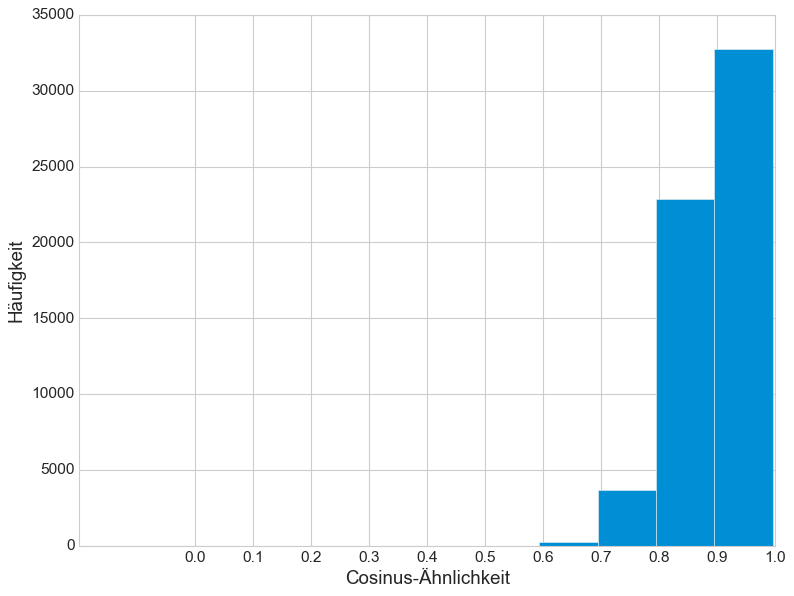

In [42]:
# Verteilung der Cosinus-Ähnlichkeit der Wörter der beiden Modelle als Histogramm

plt.figure(figsize=[10, 8])
plt.style.use('seaborn-whitegrid')
plt.hist(cosine_df['cosine'])
plt.xticks(np.arange(0, 1.1, step=0.1))
plt.xlabel('Cosinus-Ähnlichkeit')
plt.ylabel('Häufigkeit')        
#plt.savefig('../plots/VerteilungCosinusÄhnlichkeit_Shuffled.png', bbox_inches='tight')
plt.show()

In [43]:
# 5%-Quantil

border = np.quantile(cosine_df['cosine'], 0.05)
border

0.7801095962524414

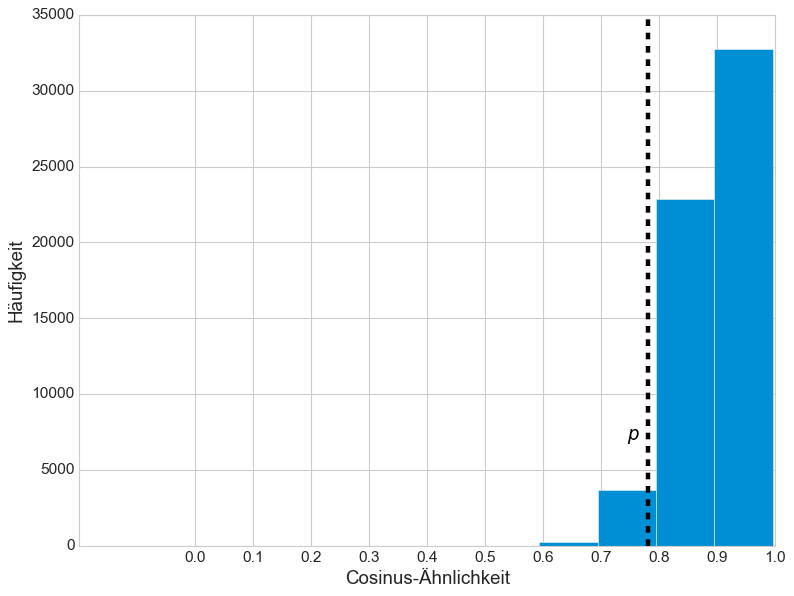

In [44]:
# Verteilung der Cosinus-Ähnlichkeit der Wörter der beiden Modelle als Histogramm

plt.figure(figsize=[10, 8])
plt.style.use('seaborn-whitegrid')
plt.hist(cosine_df['cosine'])
plt.xlabel('Cosinus-Ähnlichkeit')
plt.ylabel('Häufigkeit')       
plt.xticks(np.arange(0, 1.1, step=0.1))
plt.axvline(border, color='k', linestyle='--')
plt.text(border-0.035, 7000, 'p',color='k', fontsize=18, fontstyle='italic')
plt.legend
plt.savefig('../plots/VerteilungCosinusÄhnlichkeit_Shuffled_mitP.png', bbox_inches='tight')
plt.show()

### Ergebnis

Wie erwartet ist Cosinus-Ähnlichkeit zwischen den Vektoren der geshuffelten Modellen jeweils höher als zwischen dem Before- und After-Covid-Modell. <br>
Der Test bestätigt nochmal die Hypothese. <br>
Außerdem sind diesmal alle Werte überhalb des 5%-Quantils.

In [52]:
cosine_abstandsregel < border

False

In [53]:
cosine_querdenker < border

False

In [54]:
cosine_maske < border

False

In [55]:
cosine_corona < border

False

In [56]:
cosine_kontaktverbot < border

False